In [101]:
import numpy as np 
import pandas as pd 

/kaggle/input/carbon-dioxide/archive.csv


In [102]:
df = pd.read_csv('/kaggle/input/carbon-dioxide/archive.csv')


In [103]:
df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Year,Month,Decimal Date,Carbon Dioxide (ppm),Seasonally Adjusted CO2 (ppm),Carbon Dioxide Fit (ppm),Seasonally Adjusted CO2 Fit (ppm)
0,1958,1,1958.0411,NaN,NaN,NaN,NaN
1,1958,2,1958.1260,NaN,NaN,NaN,NaN
2,1958,3,1958.2027,315.69,314.42,316.18,314.89
3,1958,4,1958.2877,317.45,315.15,317.30,314.98
4,1958,5,1958.3699,317.50,314.73,317.83,315.06


In [104]:
df.shape

(720, 7)

In [105]:
df.describe()

,Year,Month,Decimal Date,Carbon Dioxide (ppm),Seasonally Adjusted CO2 (ppm),Carbon Dioxide Fit (ppm),Seasonally Adjusted CO2 Fit (ppm)
count,720.000000,720.000000,720.000000,703.000000,703.000000,707.000000,707.000000
mean,1987.500000,6.500000,1987.997492,352.375633,352.375206,352.054074,352.049830
std,17.330141,3.454452,17.332539,26.241884,26.171620,26.241431,26.178904
min,1958.000000,1.000000,1958.041100,313.210000,314.420000,312.450000,314.890000
25%,1972.750000,3.750000,1973.019900,328.555000,329.010000,328.340000,328.400000
50%,1987.500000,6.500000,1987.998600,349.800000,349.820000,349.370000,349.270000
75%,2002.250000,9.250000,2002.977425,373.195000,372.935000,372.840000,372.605000
max,2017.000000,12.000000,2017.956200,407.650000,406.040000,407.280000,405.830000


In [106]:
df['Date'] = pd.to_datetime(
    df['Year'].astype(int).astype(str) + '-' +
    df['Month'].astype(int).astype(str).str.zfill(2) + '-15'
)

In [107]:
df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Year,Month,Decimal Date,Carbon Dioxide (ppm),Seasonally Adjusted CO2 (ppm),Carbon Dioxide Fit (ppm),Seasonally Adjusted CO2 Fit (ppm),Date
0,1958,1,1958.0411,NaN,NaN,NaN,NaN,1958-01-15
1,1958,2,1958.1260,NaN,NaN,NaN,NaN,1958-02-15
2,1958,3,1958.2027,315.69,314.42,316.18,314.89,1958-03-15
3,1958,4,1958.2877,317.45,315.15,317.30,314.98,1958-04-15
4,1958,5,1958.3699,317.50,314.73,317.83,315.06,1958-05-15


In [108]:
df.set_index('Date', inplace=True)

In [109]:
df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Year,Month,Decimal Date,Carbon Dioxide (ppm),Seasonally Adjusted CO2 (ppm),Carbon Dioxide Fit (ppm),Seasonally Adjusted CO2 Fit (ppm)
Date,,,,,,,
1958-01-15,1958,1,1958.0411,NaN,NaN,NaN,NaN
1958-02-15,1958,2,1958.1260,NaN,NaN,NaN,NaN
1958-03-15,1958,3,1958.2027,315.69,314.42,316.18,314.89
1958-04-15,1958,4,1958.2877,317.45,315.15,317.30,314.98
1958-05-15,1958,5,1958.3699,317.50,314.73,317.83,315.06


In [110]:
series = df['Seasonally Adjusted CO2 (ppm)'].copy()
series = series.dropna()

In [111]:
series = series.diff().dropna()

In [112]:
print(f"Range after differencing: {series.min():.2f} to {series.max():.2f}")
series.head()

Range after differencing: -0.86 to 1.46


Date
1958-04-15    0.73
1958-05-15   -0.42
1958-07-15    0.44
1958-08-15    1.00
1958-09-15   -0.11
Name: Seasonally Adjusted CO2 (ppm), dtype: float64

In [113]:
μ, σ = series.mean(), series.std()
series_norm = (series - μ) / σ

In [114]:
def make_windows(x, w):
    return np.stack([x[i:i+w] for i in range(len(x)-w+1)], axis=0)


In [115]:
window_len = 30
X = make_windows(series_norm.values, window_len)
X = X[..., np.newaxis]

In [116]:
split = int(0.7 * len(X))
X_train, X_test = X[:split], X[split:]
print(f"Training on {len(X_train)} windows; testing on {len(X_test)} windows")

Training on 471 windows; testing on 202 windows


In [117]:
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model


inp = layers.Input(shape=(window_len, 1))
enc = layers.LSTM(64, return_sequences=False)(inp)
bottleneck = layers.RepeatVector(window_len)(enc)
dec = layers.LSTM(64, return_sequences=True)(bottleneck)
out = layers.TimeDistributed(layers.Dense(1))(dec)



In [118]:
autoenc = Model(inputs=inp, outputs=out)
autoenc.compile(optimizer='adam', loss='mse')
autoenc.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 30, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_4 (RepeatVector)  │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 30, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 30, 1)          │            65 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,985 (195.25 KB)

 Trainable params: 49,985 (195.25 KB)

 Non-trainable params: 0 (0.00 B)

In [119]:
history = autoenc.fit(
    X_train, X_train,
    epochs=30,
    batch_size=32,
    validation_split=0.1,
    verbose=2
)

Epoch 1/30
14/14 - 5s - 381ms/step - loss: 0.7879 - val_loss: 0.8684
Epoch 2/30
14/14 - 0s - 13ms/step - loss: 0.7827 - val_loss: 0.8644
Epoch 3/30
14/14 - 0s - 12ms/step - loss: 0.7803 - val_loss: 0.8566
Epoch 4/30
14/14 - 0s - 12ms/step - loss: 0.7762 - val_loss: 0.8435
Epoch 5/30
14/14 - 0s - 12ms/step - loss: 0.7737 - val_loss: 0.8394
Epoch 6/30
14/14 - 0s - 12ms/step - loss: 0.7718 - val_loss: 0.8343
Epoch 7/30
14/14 - 0s - 13ms/step - loss: 0.7695 - val_loss: 0.8280
Epoch 8/30
14/14 - 0s - 12ms/step - loss: 0.7652 - val_loss: 0.8257
Epoch 9/30
14/14 - 0s - 12ms/step - loss: 0.7635 - val_loss: 0.8217
Epoch 10/30
14/14 - 0s - 12ms/step - loss: 0.7631 - val_loss: 0.8212
Epoch 11/30
14/14 - 0s - 13ms/step - loss: 0.7624 - val_loss: 0.8190
Epoch 12/30
14/14 - 0s - 13ms/step - loss: 0.7621 - val_loss: 0.8232
Epoch 13/30
14/14 - 0s - 13ms/step - loss: 0.7630 - val_loss: 0.8178
Epoch 14/30
14/14 - 0s - 13ms/step - loss: 0.7630 - val_loss: 0.8180
Epoch 15/30
14/14 - 0s - 12ms/step - loss:

In [120]:
train_pred = autoenc.predict(X_train)

# 6b. Compute per‑window MSE
train_mse = np.mean((X_train - train_pred)**2, axis=(1,2))

threshold = train_mse.mean() + 3 * train_mse.std()
print(f"Anomaly threshold (MSE) = {threshold:.4f}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
Anomaly threshold (MSE) = 1.3401


In [121]:
test_pred     = autoenc.predict(X_test)
test_mse      = np.mean((X_test - test_pred)**2, axis=(1,2))

# 7b. Boolean flag array
anomaly_flags = test_mse > threshold

print(f"Detected {anomaly_flags.sum()} anomalies out of {len(test_mse)} test windows")


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Detected 45 anomalies out of 202 test windows


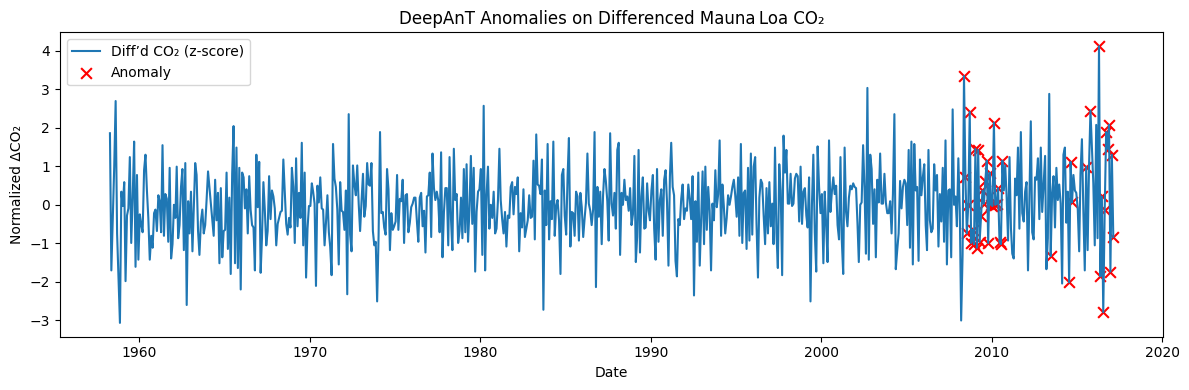

In [122]:
import matplotlib.pyplot as plt

# 8a. Compute corresponding dates for each window end
start_idx = window_len - 1 + split
dates_test = series.index[start_idx : start_idx + len(test_mse)]

# 8b. Plot
plt.figure(figsize=(12,4))
plt.plot(series.index, series_norm, label='Diff’d CO₂ (z‑score)')
plt.scatter(
    dates_test[anomaly_flags],
    series_norm.loc[dates_test[anomaly_flags]],
    marker='x', s=60, color='r',
    label='Anomaly'
)
plt.title('DeepAnT Anomalies on Differenced Mauna Loa CO₂')
plt.xlabel('Date')
plt.ylabel('Normalized ΔCO₂')
plt.legend()
plt.tight_layout()
plt.show()


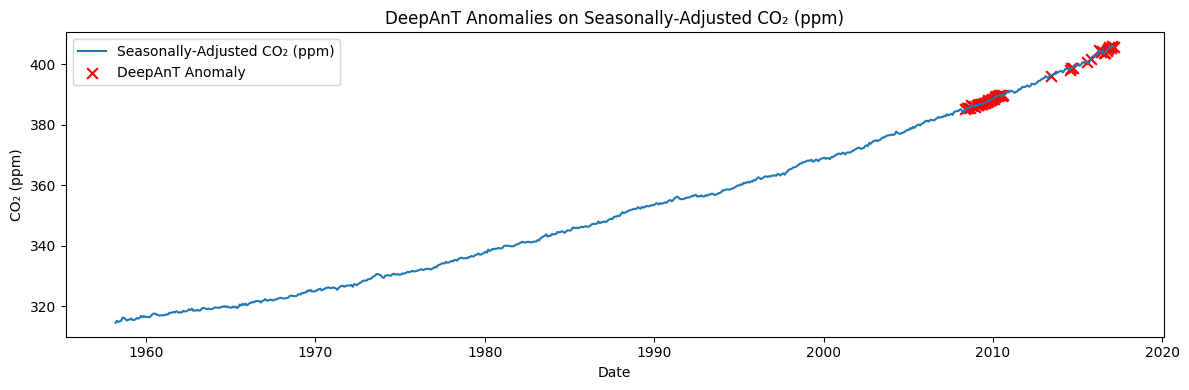

In [123]:
import matplotlib.pyplot as plt


orig_series = df['Seasonally Adjusted CO2 (ppm)'].dropna()


plt.figure(figsize=(12,4))
plt.plot(orig_series.index, orig_series.values,
         label='Seasonally‑Adjusted CO₂ (ppm)')


plt.scatter(
    dates_test[anomaly_flags],                
    orig_series.loc[dates_test[anomaly_flags]], 
    marker='x', color='r', s=60,
    label='DeepAnT Anomaly'
)

plt.title('DeepAnT Anomalies on Seasonally‑Adjusted CO₂ (ppm)')
plt.xlabel('Date')
plt.ylabel('CO₂ (ppm)')
plt.legend()
plt.tight_layout()
plt.show()


In [124]:

for dt in dates_test[anomaly_flags]:
    print(dt.date(), "ΔCO₂ =", series.loc[dt], "ppm")


2008-05-15 ΔCO₂ = 1.2099999999999795 ppm
2008-06-15 ΔCO₂ = 0.36000000000001364 ppm
2008-07-15 ΔCO₂ = -0.11000000000001364 ppm
2008-08-15 ΔCO₂ = 0.12999999999999545 ppm
2008-09-15 ΔCO₂ = 0.910000000000025 ppm
2008-10-15 ΔCO₂ = -0.18999999999999773 ppm
2008-11-15 ΔCO₂ = -0.07999999999998408 ppm
2008-12-15 ΔCO₂ = -0.20000000000004547 ppm
2009-01-15 ΔCO₂ = 0.6000000000000227 ppm
2009-02-15 ΔCO₂ = -0.2300000000000182 ppm
2009-03-15 ΔCO₂ = 0.5900000000000318 ppm
2009-04-15 ΔCO₂ = -0.18000000000000682 ppm
2009-05-15 ΔCO₂ = 0.040000000000020464 ppm
2009-06-15 ΔCO₂ = 0.25 ppm
2009-07-15 ΔCO₂ = 0.13999999999998636 ppm
2009-08-15 ΔCO₂ = 0.3299999999999841 ppm
2009-09-15 ΔCO₂ = 0.5 ppm
2009-10-15 ΔCO₂ = -0.18999999999999773 ppm
2009-11-15 ΔCO₂ = 0.39999999999997726 ppm
2009-12-15 ΔCO₂ = 0.1300000000000523 ppm
2010-01-15 ΔCO₂ = 0.1199999999999477 ppm
2010-02-15 ΔCO₂ = 0.82000000000005 ppm
2010-03-15 ΔCO₂ = 0.12999999999999545 ppm
2010-04-15 ΔCO₂ = 0.13999999999998636 ppm
2010-05-15 ΔCO₂ = 0.2699999